goal
- extend gp to handle multiclass classification
    - robust softmax for SVGP https://gpflow.readthedocs.io/en/master/notebooks/advanced/multiclass_classification.html
    - multiclass softmax with mc integration
    - dirichlet approx with lognormal 

In [2]:
# Reference:
#    

import time
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"


import scipy
import numpy as onp
onp.set_printoptions(precision=3,suppress=True)

import jax
import jax.numpy as np
from jax import grad, jit, vmap, device_put, random
from flax import linen as nn
from jax.scipy.stats import dirichlet
# jax.config.update('jax_platform_name', 'cpu')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.tri as tri
# https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 25
mpl.rcParams['font.family'] = 'Times New Roman' 
cmap = plt.cm.get_cmap('bwr')

from tabulate import tabulate

from plt_utils import *
from gpax import *


In [3]:
## Parameters

# Number of functions and number of data points
C = 3
N = 100
ℓ = .1

## Data

# Input
key = random.PRNGKey(2)
X = random.uniform(key, (N, 1))

k = CovSE(init_val_l=ℓ)
k_params = k.init(key, X)
k = k.bind(k_params)
K = k(X) + np.eye(N) * 5e-5

print(np.mean(K))

f = random.multivariate_normal(key, mean=np.zeros(N), cov=K, shape=(C,)).T
Y = np.argmax(f, 1).reshape(-1,).astype(np.int32)
Y_hot = jax.nn.one_hot(Y, C)
print(X.shape, Y_hot.shape)

data = (X, Y)

0.24605191
(100, 1) (100, 3)


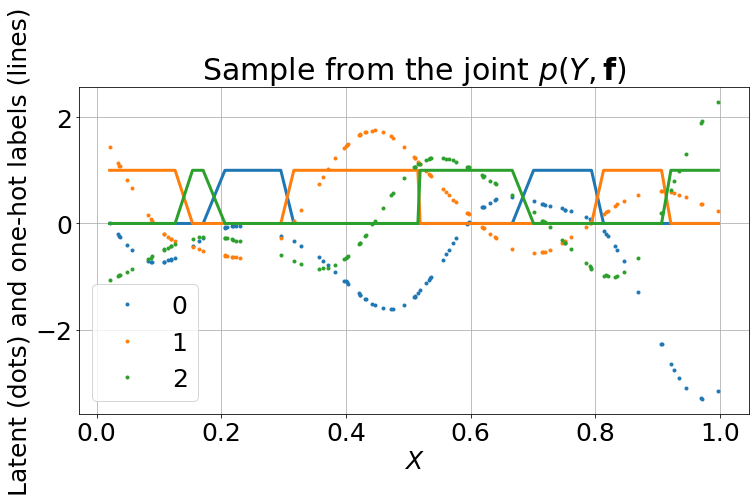

In [4]:


colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):
    plt.plot(X[order], f[order, c], ".", color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], "-", color=colors[c])


plt.legend()
plt.xlabel("$X$")
plt.ylabel("Latent (dots) and one-hot labels (lines)")
plt.title("Sample from the joint $p(Y, \mathbf{f})$")
plt.grid()
plt.show()

In [5]:
C = 3
α_ϵ = 1; α_δ = 10; n_mc_samples = 20
apx_gamma = False
lik_type = 'LikMulticlassDirichlet' # LikMulticlassDirichlet, LikMulticlassSoftmax, LikMultipleNormalKron
init_val_m = gamma_to_lognormal(np.array([1.]))[0] \
    if lik_type == 'LikMulticlassDirichlet' else np.array([.5])


mean_fn_cls = partial(MeanConstant, output_dim=C, init_val_m=init_val_m, flat=False)
if lik_type == 'LikMulticlassDirichlet':
    lik_cls = partial(LikMulticlassDirichlet, output_dim=C,
                      init_val_α_ϵ=α_ϵ, init_val_α_δ=α_δ, n_mc_samples=n_mc_samples)
elif lik_type == 'LikMulticlassSoftmax':
    lik_cls = partial(LikMulticlassSoftmax, output_dim=C, n_mc_samples=n_mc_samples, apx_gamma=apx_gamma)
else:
    lik_cls = partial(LikMultipleNormalKron, output_dim=C)

kx_cls = partial(CovSE, output_scaling=True)
k_cls = partial(CovMultipleOutputIndependent, k_cls=kx_cls, output_dim=C)
Xu_initial = data[0].copy()
inducing_loc_cls = partial(InducingLocations,
                           shape=(len(Xu_initial), 1),
                           init_fn_inducing=lambda k,s: Xu_initial)


model = SVGP(mean_fn_cls=mean_fn_cls,
             k_cls=k_cls,
             lik_cls=lik_cls,
             inducing_loc_cls=inducing_loc_cls,
             n_data=N,
             output_dim=C)


params = model.get_init_params(model, key)
params = pytree_mutate(params, {'params/k/kx/ls': softplus_inv(np.array([.5])),
                                'params/k/ks_0/ls': softplus_inv(np.array([.5])),
                                'params/k/ks_1/ls': softplus_inv(np.array([.5])),
                                'params/k/ks_2/ls': softplus_inv(np.array([.5])),})
params

TypeError: __init__() got an unexpected keyword argument 'init_fn_inducing'

In [ ]:
######################################################
opt = flax_create_multioptimizer_2focus(params, 'Adam',
                                        [{'learning_rate': 0.}, {'learning_rate': 0.002}],
                                        ['mean_fn'])

bsz = 32
n_batches, batches = get_data_stream(
    key, bsz, (X, Y_hot))


@jax.jit
def train_step(step, opt, batch, key):
    key, subkey = random.split(key)
    def f(params):
        fx = model.apply(params,
                         batch,
                         method=model.mll,
                         rngs={'lik_mc_samples': subkey})
        return -fx, {}
    fg_fn = jax.value_and_grad(f, has_aux=True)
    (value, aux), grad = fg_fn(opt.target)
    opt = opt.apply_gradient(grad)
    log = {'step': step,
           'loss': value,
           'lik.α_ϵ': jax.nn.softplus(pytree_leaf(opt.target, 'params/lik/α_ϵ')),
           'k.ls': jax.nn.softplus(pytree_leaf(opt.target, f'params/k/kx/ls')
                                   if isinstance(model.k_cls(), CovICM) else 
                                   np.hstack([pytree_leaf(opt.target, f'params/k/ks_{i}/ls')
                                              for i in range(C)])),
           'k.σ2': jax.nn.softplus(pytree_leaf(opt.target, f'params/k/kx/σ2')
                                   if isinstance(model.k_cls(), CovICM) else 
                                   np.hstack([pytree_leaf(opt.target, f'params/k/ks_{i}/σ2')
                                              for i in range(C)])), }
    return opt, log, key

num_steps = 1500 # ; num_steps = 1

for epoch in range(num_steps):
    for it in range(n_batches):
        step = epoch*n_batches+it
        batch = next(batches)
        opt, log, key = train_step(step, opt, batch, key)
        if step%(num_steps*n_batches//50)==0:
            print(f'[{epoch:3}|{100*it/n_batches:5.2f}%]\t'
                  f'Loss={log["loss"]:.3f}\t'
                  f'lik.α_ϵ={log["lik.α_ϵ"]:.3f}\t'
                  f'k.ls={onp.array(log["k.ls"])}\t'
                  f'k.σ2={onp.array(log["k.σ2"])}\t')

params = opt.target
m = model.bind(params, rngs={'lik_mc_samples': key})

In [ ]:

params = opt.target
m = model.bind(params, rngs={'lik_mc_samples': key})

xx = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
mu, var = m.pred_f(xx, full_cov=False)
mu = mu.reshape(-1,3); var = var.reshape(-1,3)

α1 = gamma_to_lognormal_inv(mu, var, approx_type='kl')
α2 = gamma_to_lognormal_inv(mu, var, approx_type='moment')
α3 = gamma_to_lognormal_inv(mu, var, approx_type='mc1', mc_n_samples=5000)
α4 = 1/var
α1 = α1.reshape((-1,3))
α2 = α2.reshape((-1,3))
α3 = α3.reshape((-1,3))


c = 0
fig, axs = plt.subplots(4,1,figsize=(10,20))
    
ax = axs[0]
ax.plot(np.arange(len(var)), 1/var[:,c])

for i in range(3):
    ax = axs[i+1]
    ax.plot(np.arange(len(α1)), α1[:,c], '.', label=f'kl')
    ax.plot(np.arange(len(α1)), α2[:,c], '--',label=f'mt')
    ax.plot(np.arange(len(α1)), α3[:,c], 'x', label=f'mc')
    ax.legend()

    

axs[2].set_ylim((0,2))
axs[3].set_ylim((np.max(α3[:,0])/4,np.max(α3[:,0])+.5))

In [ ]:


fig = plt.figure(figsize=(12, 12))
a1 = fig.add_axes([0.05, 0.05, 0.9, 0.6])
a2 = fig.add_axes([0.05, 0.7, 0.9, 0.1])
a3 = fig.add_axes([0.05, 0.85, 0.9, 0.1])

xx = np.linspace(X.min()-.5, X.max()+.5, 200).reshape(-1, 1)
mu, var = m.pred_f(xx, full_cov=False)
if isinstance(model.lik_cls(), LikMulticlassSoftmax):
    p, pvar = model.apply(params, xx,full_cov=False, 
                               method=model.pred_y,
                               rngs={'lik_mc_samples': key})
    p = p.reshape(-1,3)
    pvar = pvar.reshape(-1,3)
    
    α = 1/var
    α0 = np.sum(α, axis=-1, keepdims=True)
    p = α / α0
    pvar = p*(1-p)
elif isinstance(model.lik_cls(), LikMulticlassDirichlet):
    α = np.real(1/(scipy.special.lambertw(1/(2*np.exp(mu.reshape(-1,3))))*2))
    α = α.reshape(-1,3)
    α0 = np.sum(α, axis=-1, keepdims=True)
    p = α / α0
    pvar = p*(1-p)
    
    
    
mu = mu.reshape(-1,3)
# mu = np.exp(mu)
var = var.reshape(-1,3)


a3.set_xticks([])
a3.set_yticks([])

for c in range(C):
    x = data[0][Y.flatten() == c]

    color = colors[c]
    a1.plot(xx, mu[:, c], color=color, lw=2, label="%d" % c)
    a1.plot(xx, mu[:, c] + 2 * np.sqrt(var[:, c]), "--", color=color)
    a1.plot(xx, mu[:, c] - 2 * np.sqrt(var[:, c]), "--", color=color)
    if isinstance(model.lik_cls(), LikMulticlassSoftmax) or \
        isinstance(model.lik_cls(), LikMulticlassDirichlet):
        a2.plot(xx, p[:, c], "-", color=color, lw=2)
        a2.fill_between(xx.squeeze(), p[:, c] - 2 * np.sqrt(pvar[:, c]),
                            p[:, c] + 2 * np.sqrt(pvar[:, c]), alpha=.2, color=color)
    else:
        a2.plot(xx, mu[:, c], "-", color=color, lw=2)
    a3.plot(x, x * 0, ".", color=color)
    
        

# a2.set_ylim(-0.1, 1.1)
# a2.set_yticks([0, 1])
a2.set_xticks([])
a3.set_xlim((xx.min(), xx.max()))


a3.set_title("inputs X", fontsize=12)
a2.set_title(
    "predicted mean label value \
             $\mathbb{E}_{q(\mathbf{u})}[y^*|x^*, Z, \mathbf{u}]$", fontsize=12)
a1.set_title(
    "posterior process \
            $\int d\mathbf{u} q(\mathbf{u})p(f^*|\mathbf{u}, Z, x^*)$", fontsize=12)

handles, labels = a1.get_legend_handles_labels()
a1.legend(handles, labels)
fig.tight_layout()
plt.show()


In [ ]:
from scipy import interpolate

# α = np.linspace(0.001,10,200)
α = np.linspace(1e-10,100,2000)
# σ2 = np.log( 1/α + 1 )
σ2 = 1/α
y = np.log(α) - σ2/2
interp_fn = interpolate.interp1d(y, α)

xx = np.linspace(X.min(), X.max()*2, 200).reshape(-1, 1)
μf, σ2f = m.pred_f(xx, full_cov=False)
μf = μf.reshape(-1,C); σ2f = σ2f.reshape(-1,C)
# αf = interp_fn(μf)
αf = np.real(1/(scipy.special.lambertw(1/(2*np.exp(μf)))*2))

# inds = np.asarray(np.array([.4, .5, .6])*len(xx), np.int32)
inds = np.array([15,40,140])
L = 500

fig, axs = plt.subplots(1, 3, figsize=(15,5))
for i, ind in enumerate(inds):
    αᵢ = αf[ind]; μfᵢ = μf[ind]; σ2fᵢ = σ2f[ind]
    fs = μfᵢ + random.normal(key, (L,3))*np.sqrt(σ2fᵢ)
    π = jax.nn.softmax(fs)
    Eπ = np.mean(π, axis=0)
    print(ind, Eπ, αᵢ)
    print(np.mean(np.exp(fs),axis=0), np.sum(np.mean(np.exp(fs),axis=0)))
    ax = axs[i]
    plt_2simplex_dirichlet_pdf(ax, np.mean(np.exp(fs),axis=0), log_scale=True,
                               levels=20, cmap='plasma', vertexlabels=('0','1','2'))
    plt_2simplex_scatter(ax, π, c='b', alpha=.2, vertexlabels=('0','1','2'))
    plt_2simplex_scatter(ax, [Eπ], c='r', vertexlabels=('0','1','2'))

# 15 [0.164 0.112 0.725] [ 2.419  1.712 10.329]
# [ 2.246  1.539 10.111] 13.896001
# 40 [0.06  0.882 0.058] [ 0.985 10.363  0.971]
# [0.682 9.952 0.661] 11.295441
# 102 [0.183 0.209 0.608] [1.242 1.385 4.245]
# [1.271 1.495 4.34 ] 7.106011

In [ ]:

from jax.scipy.stats import dirichlet

αᵢ = np.array([1,1.2,1.3])*.9
αᵢ = np.array([.8,.01,.001])
# αᵢ = np.array([3.,2.,3.])
# αᵢ = np.array([1.,1.,1.])
# αᵢ = np.array([0.435, 0.151, 0.147])

logpdf = True

dir_pdf = lambda X: np.log(dirichlet.pdf(X.T, αᵢ)+1e-5) if logpdf else dirichlet.pdf(X.T, αᵢ)
vertexlabels = ('0','1','2')

def _draw_axes(ax, vertexlabels):
#     l1 = mpl.lines.Line2D([0, 0.5, 1.0, 0], [0, np.sqrt(3) / 2, 0, 0],
#                           color="k", linewidth=1, antialiased=True)
#     ax.add_line(l1)
    ax.text(-0.05, -0.05, vertexlabels[0], ha='right')
    ax.text(1.05, -0.05, vertexlabels[1], ha='left')
    ax.text(0.5, np.sqrt(3) / 2 + 0.05, vertexlabels[2], ha='center')
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.set_aspect("equal")
    ax.legend()
    
fig, ax = plt.subplots(1,1,figsize=(10,10))

n = 200
x = np.linspace(0, 1, n)
y = np.linspace(0, np.sqrt(3.0) / 2.0, n)
points2d = np.transpose(np.array([np.tile(x, len(y)), np.repeat(y, len(x))]))
points3d = barycentric(points2d)
valid = (points3d.sum(axis=1) == 1.0) & ((0.0 <= points3d).all(axis=1))
points2d = points2d[np.where(valid), :][0]
points3d = points3d[np.where(valid), :][0]
z = dir_pdf(points3d)+1e-5
ax.tricontourf(points2d[:, 0], points2d[:, 1], z, levels=20, cmap='Greys')
# _draw_axes(ax, vertexlabels)

np.min(z), np.mean(z), np.max(z), np.min(cmap_norm(z))

In [ ]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):
    plt.plot(X[order], f[order, c], ".", color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], "-", color=colors[c])


plt.legend()
plt.xlabel("$X$")
plt.ylabel("Latent (dots) and one-hot labels (lines)")
plt.title("Sample from the joint $p(Y, \mathbf{f})$")
plt.grid()
plt.show()

In [ ]:
# plot_posterior_predictions(m, X, Y)


fig = plt.figure(figsize=(12, 6))
a1 = fig.add_axes([0.05, 0.05, 0.9, 0.6])
a2 = fig.add_axes([0.05, 0.7, 0.9, 0.1])
a3 = fig.add_axes([0.05, 0.85, 0.9, 0.1])

xx = np.linspace(X.min(), X.max(), 200).reshape(-1, 1)
mu, var = m.pred_f(xx, full_cov=False)
# p, _ = m.pred_y(xx, full_cov=False)

mu = mu.reshape(-1,3)
var = var.reshape(-1,3)
# p = p.reshape(-1,3)


a3.set_xticks([])
a3.set_yticks([])

for c in range(C):
    x = X[Y.flatten() == c]

    color = colors[c]
    a1.plot(xx, mu[:, c], color=color, lw=2, label="%d" % c)
    a1.plot(xx, mu[:, c] + 2 * np.sqrt(var[:, c]), "--", color=color)
    a1.plot(xx, mu[:, c] - 2 * np.sqrt(var[:, c]), "--", color=color)
    a2.plot(xx, mu[:, c], "-", color=color, lw=2)
    a3.plot(x, x * 0, ".", color=color)

a2.set_ylim(-0.1, 1.1)
a2.set_yticks([0, 1])
a2.set_xticks([])

a3.set_title("inputs X", fontsize=12)
a2.set_title(
    "predicted mean label value \
             $\mathbb{E}_{q(\mathbf{u})}[y^*|x^*, Z, \mathbf{u}]$", fontsize=12)
a1.set_title(
    "posterior process \
            $\int d\mathbf{u} q(\mathbf{u})p(f^*|\mathbf{u}, Z, x^*)$", fontsize=12)

handles, labels = a1.get_legend_handles_labels()
a1.legend(handles, labels)
fig.tight_layout()
plt.show()
